# Sheet 9

## 2 Under the hood of LLMs: Llama 2.7B

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open("access_token.txt", "r") as f:
    access_token = f.read().strip()

model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model, token=access_token, torch_dtype = torch.float16).to(device)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

In [2]:
for id in range(5100, 5110):
    print(f"{id=}, {tokenizer.decode([id])}")

print("\ntokenizer length:", len(tokenizer))

sun_id = tokenizer.encode("sun", return_tensors="pt")[-1]
print(f"\n{sun_id=}")

print(tokenizer.decode(sun_id))

emb = model.get_input_embeddings()(sun_id.to(device))
print("embedding shape:", emb.shape)

id=5100, compet
id=5101, pair
id=5102, inglés
id=5103, Response
id=5104, Fig
id=5105, grad
id=5106, documentation
id=5107, cant
id=5108, appreci
id=5109, ån

tokenizer length: 32000

sun_id=tensor([   1, 6575])
<s> sun
embedding shape: torch.Size([2, 4096])


In [3]:
sequence = "My favorite composer is"
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)
print(tokenizer.decode(model_inputs["input_ids"].tolist()[0])) # view tokenized input
with torch.no_grad():
    outputs = model(**model_inputs)

logits = outputs['logits'][0, -1, :]
print("\nlogits shape:", logits.shape)

probabilities = torch.nn.functional.softmax(logits, dim=-1)
top_k = 7
top_prob, top_ind = torch.topk(probabilities, top_k)

print("\nOutputs:\n")

for i in range(top_k):
    print(f"{tokenizer.decode(top_ind[i].tolist())}: {top_prob[i]:.2f}")

<s> My favorite composer is

logits shape: torch.Size([32000])

Outputs:

Moz: 0.25
Ch: 0.11
Be: 0.09
Ludwig: 0.08
Fr: 0.03
Wolfgang: 0.02
Ig: 0.02


In [4]:
import regex as re

sequence = ""
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)

generated_answer = ""
for _ in range(30):
    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs['logits'][0, -1, :]
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        next_token_id = torch.argmax(probabilities).unsqueeze(0)
        model_inputs["input_ids"] = torch.cat([model_inputs["input_ids"], next_token_id.unsqueeze(0)], dim=-1)
    
    next_word = tokenizer.decode(next_token_id.tolist())
    next_word = re.sub(r"[^a-zA-Z0-9.?!]", "", next_word)
    generated_answer += next_word
    generated_answer += " "
    
    print(generated_answer)

Unterscheidung 
Unterscheidung zwischen 
Unterscheidung zwischen  
Unterscheidung zwischen  K 
Unterscheidung zwischen  K raft 
Unterscheidung zwischen  K raft  
Unterscheidung zwischen  K raft  und 
Unterscheidung zwischen  K raft  und  
Unterscheidung zwischen  K raft  und  K 
Unterscheidung zwischen  K raft  und  K raft 
Unterscheidung zwischen  K raft  und  K raft werk 
Unterscheidung zwischen  K raft  und  K raft werk  
Unterscheidung zwischen  K raft  und  K raft werk   
Unterscheidung zwischen  K raft  und  K raft werk    
Unterscheidung zwischen  K raft  und  K raft werk     
Unterscheidung zwischen  K raft  und  K raft werk     K 
Unterscheidung zwischen  K raft  und  K raft werk     K raft 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  K 
Unterscheidung zwische

## 3 Flow-based modeling

### (b)

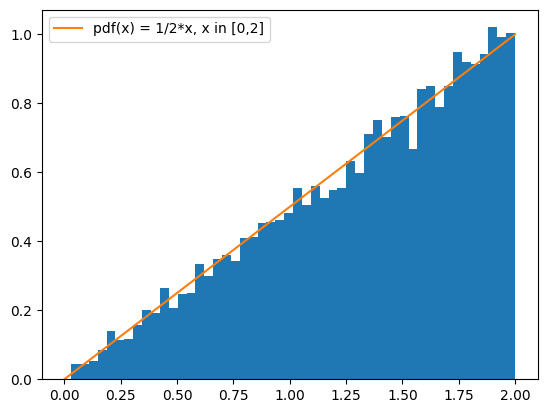

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# load the 1d samples:
samples = np.load("data/samples_1d.npy")

x_lin = np.linspace(0, 2, 1000)
plt.hist(samples, bins=50, density=True)
plt.plot(x_lin, 1/2 * x_lin, label="pdf(x) = 1/2*x, x in [0,2]")
plt.legend()
plt.show()

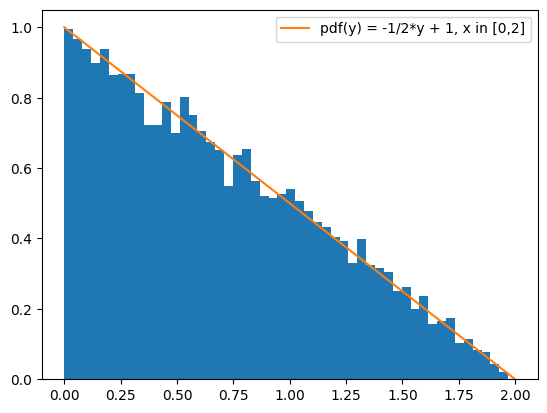

In [4]:
# TODO: transform the samples to samples from pdf(y) = -1/2*y + 1, y in [0,2]

y =2 - np.sqrt(4 - samples**2)

plt.hist(y, bins=50, density=True)
plt.plot(x_lin, - 1/2 * x_lin + 1, label="pdf(y) = -1/2*y + 1, x in [0,2]")
plt.legend()
plt.show()